In [1]:
import torch
import ugs_sampler
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
n = 10; k = 6

G_edge_index = torch.tensor([[0,1,2,3,4,5,5,6,7,8,9],
                           [1,2,3,4,5,0,6,7,8,9,0]], dtype=torch.long)
G_node_color = {
    0:"yellow",1:"blue",2:"red",3:"red",4:"blue",5:"yellow",6:"blue",7:"red",8:"red",9:"blue"
}

H_edge_index = torch.tensor([[0,1,2,3,4,5,0,6,7,8,9],
                            [1,2,3,4,5,1,6,7,8,9,0]], dtype=torch.long)
H_node_color = {
    0:"yellow",1:"yellow",2:"blue",3:"red",4:"red",5:"blue",6:"blue",7:"red",8:"red",9:"blue"
}

In [53]:
def draw_subgraphs(edge_index,n,k,node_color=None):
    handle = ugs_sampler.create_preproc(edge_index, n, k)
    nodes, edge_index_s, edge_ptr, graph_id = ugs_sampler.sample(handle, m_per_graph=40, k=k)
    B = nodes.size(0)
    fig, axes = plt.subplots(8,5,figsize=(20,20))
    axes = axes.flatten()
    for b in range(B):
        global_nodes = nodes[b].tolist()
        valid = [i for i,v in enumerate(global_nodes) if v>=0]
        mapping = {i: global_nodes[i] for i in valid}

        start, end = edge_ptr[b].item(), edge_ptr[b+1].item()
        local_edges = edge_index_s[:,start:end].T.tolist()

        G = nx.Graph()
        G.add_nodes_from(mapping.values())
        for u,v in local_edges:
            G.add_edge(mapping[u], mapping[v])
        
        if node_color != None:
            node_color_s = [node_color[i] for i in mapping.values()]
        else:
            node_color_s = ["lightblue" for i in mapping.values()]
            
        nx.draw(G,with_labels=True, ax=axes[b], node_color=node_color_s)
        axes[b].set_title(f"Sample:{b}")
   
    plt.show()

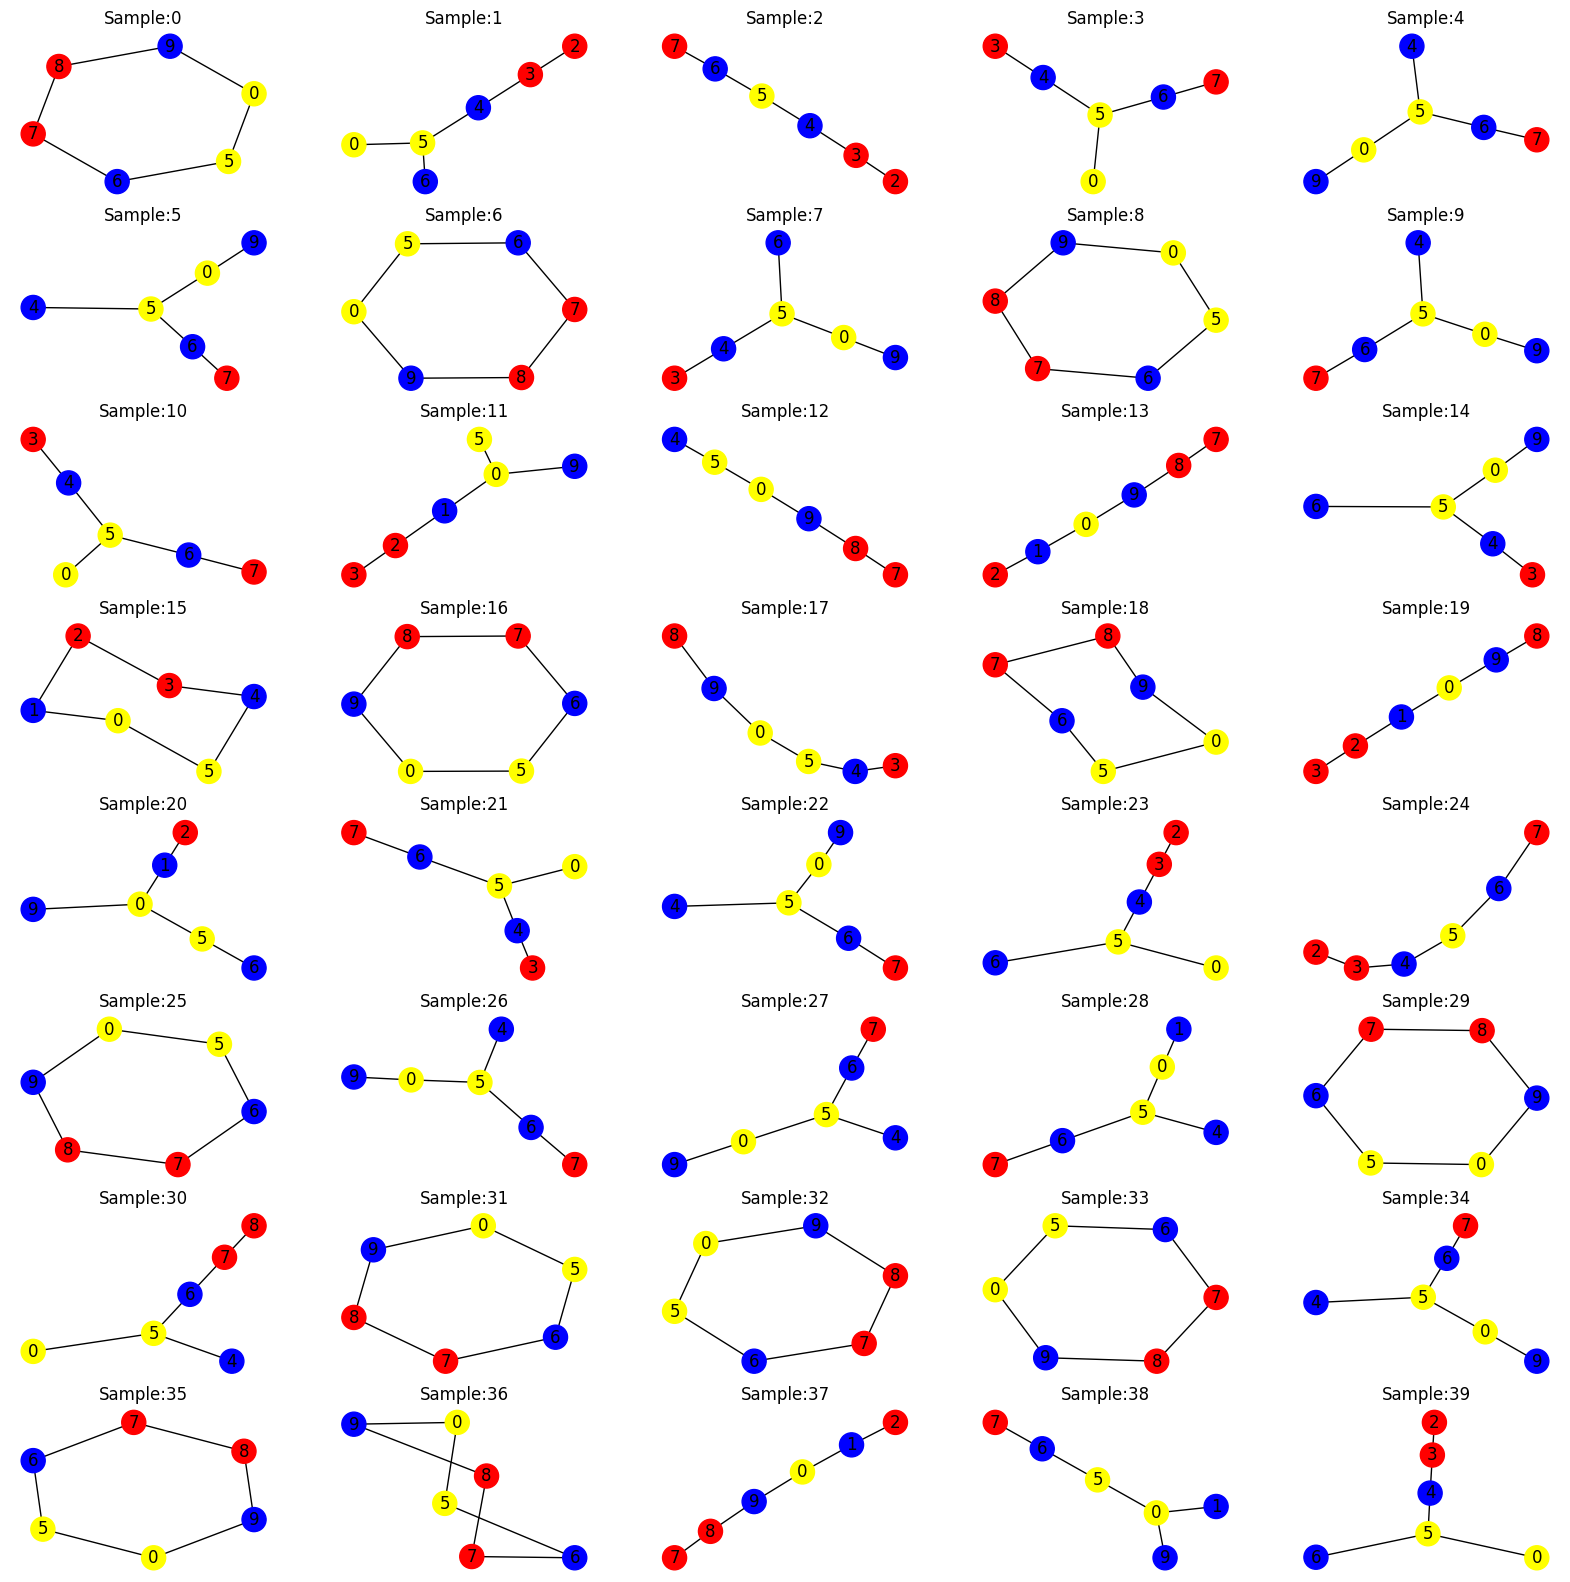

In [54]:
draw_subgraphs(G_edge_index, n, k, G_node_color)

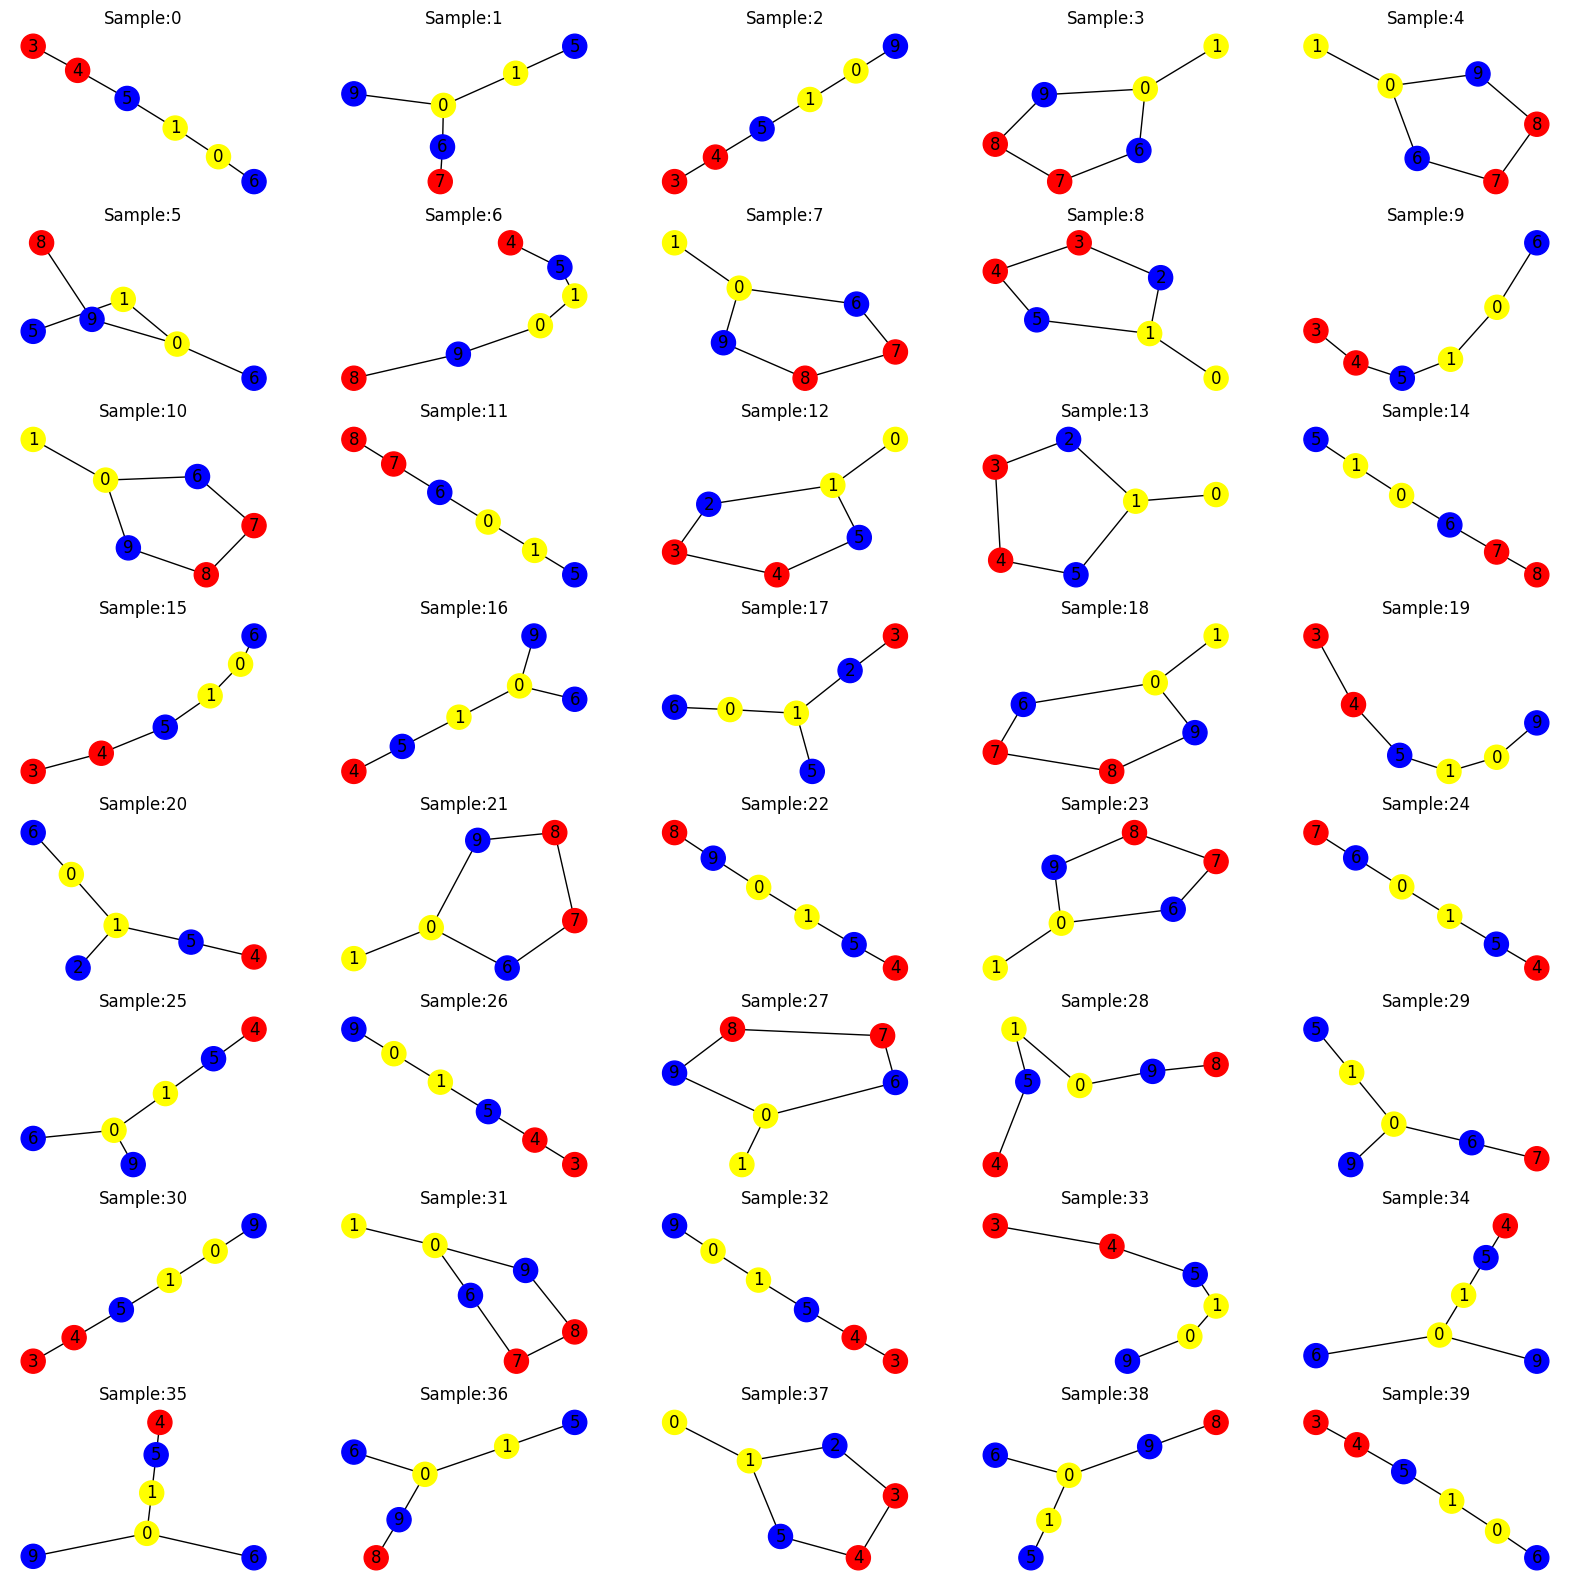

In [55]:
draw_subgraphs(H_edge_index, n, k, H_node_color)

In [22]:
def subgraph_wl_dist(edge_index,sample_size, n, k,node_color=None):
    handle = ugs_sampler.create_preproc(edge_index, n, k)
    nodes, edge_index_s, edge_ptr, graph_id = ugs_sampler.sample(handle, m_per_graph=sample_size, k=k)
    B = nodes.size(0)
    hashs = []
    for b in range(B):
        global_nodes = nodes[b].tolist()
        start, end = edge_ptr[b].item(), edge_ptr[b+1].item()
        local_edges = edge_index_s[:,start:end].T.tolist()
        G = nx.Graph()
        G.add_nodes_from(global_nodes)
        for u,v in local_edges:
            G.add_edge(global_nodes[u],global_nodes[v])

        if node_color != None:
            node_color_s = {i:node_color[i] for i in global_nodes}
            nx.set_node_attributes(G, node_color_s, "color")
            wl_hash = nx.weisfeiler_lehman_graph_hash(G,node_attr="color",iterations=k)
        else:
            wl_hash = nx.weisfeiler_lehman_graph_hash(G,iterations=k)
        hashs.append(wl_hash)
    return Counter(hashs)

In [26]:
subgraph_wl_dist(G_edge_index,30,n,6,G_node_color)

Counter({'5fa67e0aaafa21dd9262dd06d2d754f4': 10,
         '836a3f1ab0647d2b1dc28dea60fa9560': 6,
         '250f5f9aa312af4993e83072a1d8245b': 5,
         'd5a4bf780d1954112b55431f430af700': 4,
         '969ac2de38b113f1061f405e75db30bc': 2,
         'b8ad39c8d4adac889694950e55d9030f': 2,
         '1b0746aca5e3e353a6df1b0037b52c4a': 1})

In [25]:
subgraph_wl_dist(H_edge_index, 30, n, 6, H_node_color)

Counter({'7996501f99ad050aadf04ae2cc5a8e57': 8,
         'b8ad39c8d4adac889694950e55d9030f': 6,
         '250f5f9aa312af4993e83072a1d8245b': 6,
         '969ac2de38b113f1061f405e75db30bc': 5,
         '1b0746aca5e3e353a6df1b0037b52c4a': 5})

In [29]:
subgraph_wl_dist(G_edge_index, 1,n, 10, G_node_color)

Counter({'20115126cf91fc3051d2ce56984b7c72': 1})

In [30]:
subgraph_wl_dist(H_edge_index, 1,n, 10, H_node_color)

Counter({'20115126cf91fc3051d2ce56984b7c72': 1})

In [44]:
Shrekhande_edge_index = torch.tensor([
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
  4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
  8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,10,10,10,10,10,10,11,11,11,11,11,11,
 12,12,12,12,12,12,13,13,13,13,13,13,14,14,14,14,14,14,15,15,15,15,15,15],
 [1, 3, 4, 5,12,15, 0, 2, 5, 6,12,13, 1, 3, 6, 7,13,14, 0, 2, 4, 7,14,15,
  0, 6, 8, 9,12,14, 1, 5, 9,10,12,13, 2, 6,10,11,13,15, 0, 3, 8,11,12,15,
  0, 4, 9,10, 8,11, 1, 5,10,11,13,14, 2, 3, 8, 9,13,15, 1, 4, 2, 7, 9,14,
  0, 3, 4, 7, 8,11, 1, 5, 6, 7,10,15, 2, 3, 6,10,14,15, 0, 1, 2, 3,12,14]
]
, dtype=torch.long)

Rooks_edge_index = torch.tensor([
 [0,1, 0,2, 0,3, 1,2, 1,3, 2,3,
  4,5, 4,6, 4,7, 5,6, 5,7, 6,7,
  8,9, 8,10, 8,11, 9,10, 9,11, 10,11,
  12,13, 12,14, 12,15, 13,14, 13,15, 14,15,
  0,4, 0,8, 0,12, 4,8, 4,12, 8,12,
  1,5, 1,9, 1,13, 5,9, 5,13, 9,13,
  2,6, 2,10, 2,14, 6,10, 6,14, 10,14,
  3,7, 3,11, 3,15, 7,11, 7,15, 11,15],
 [1,0, 2,0, 3,0, 2,1, 3,1, 3,2,
  5,4, 6,4, 7,4, 6,5, 7,5, 7,6,
  9,8, 10,8, 11,8, 10,9, 11,9, 11,10,
  13,12, 14,12, 15,12, 14,13, 15,13, 15,14,
  4,0, 8,0, 12,0, 8,4, 12,4, 12,8,
  5,1, 9,1, 13,1, 9,5, 13,5, 13,9,
  6,2, 10,2, 14,2, 10,6, 14,6, 14,10,
  7,3, 11,3, 15,3, 11,7, 15,7, 15,11]
], dtype=torch.long)


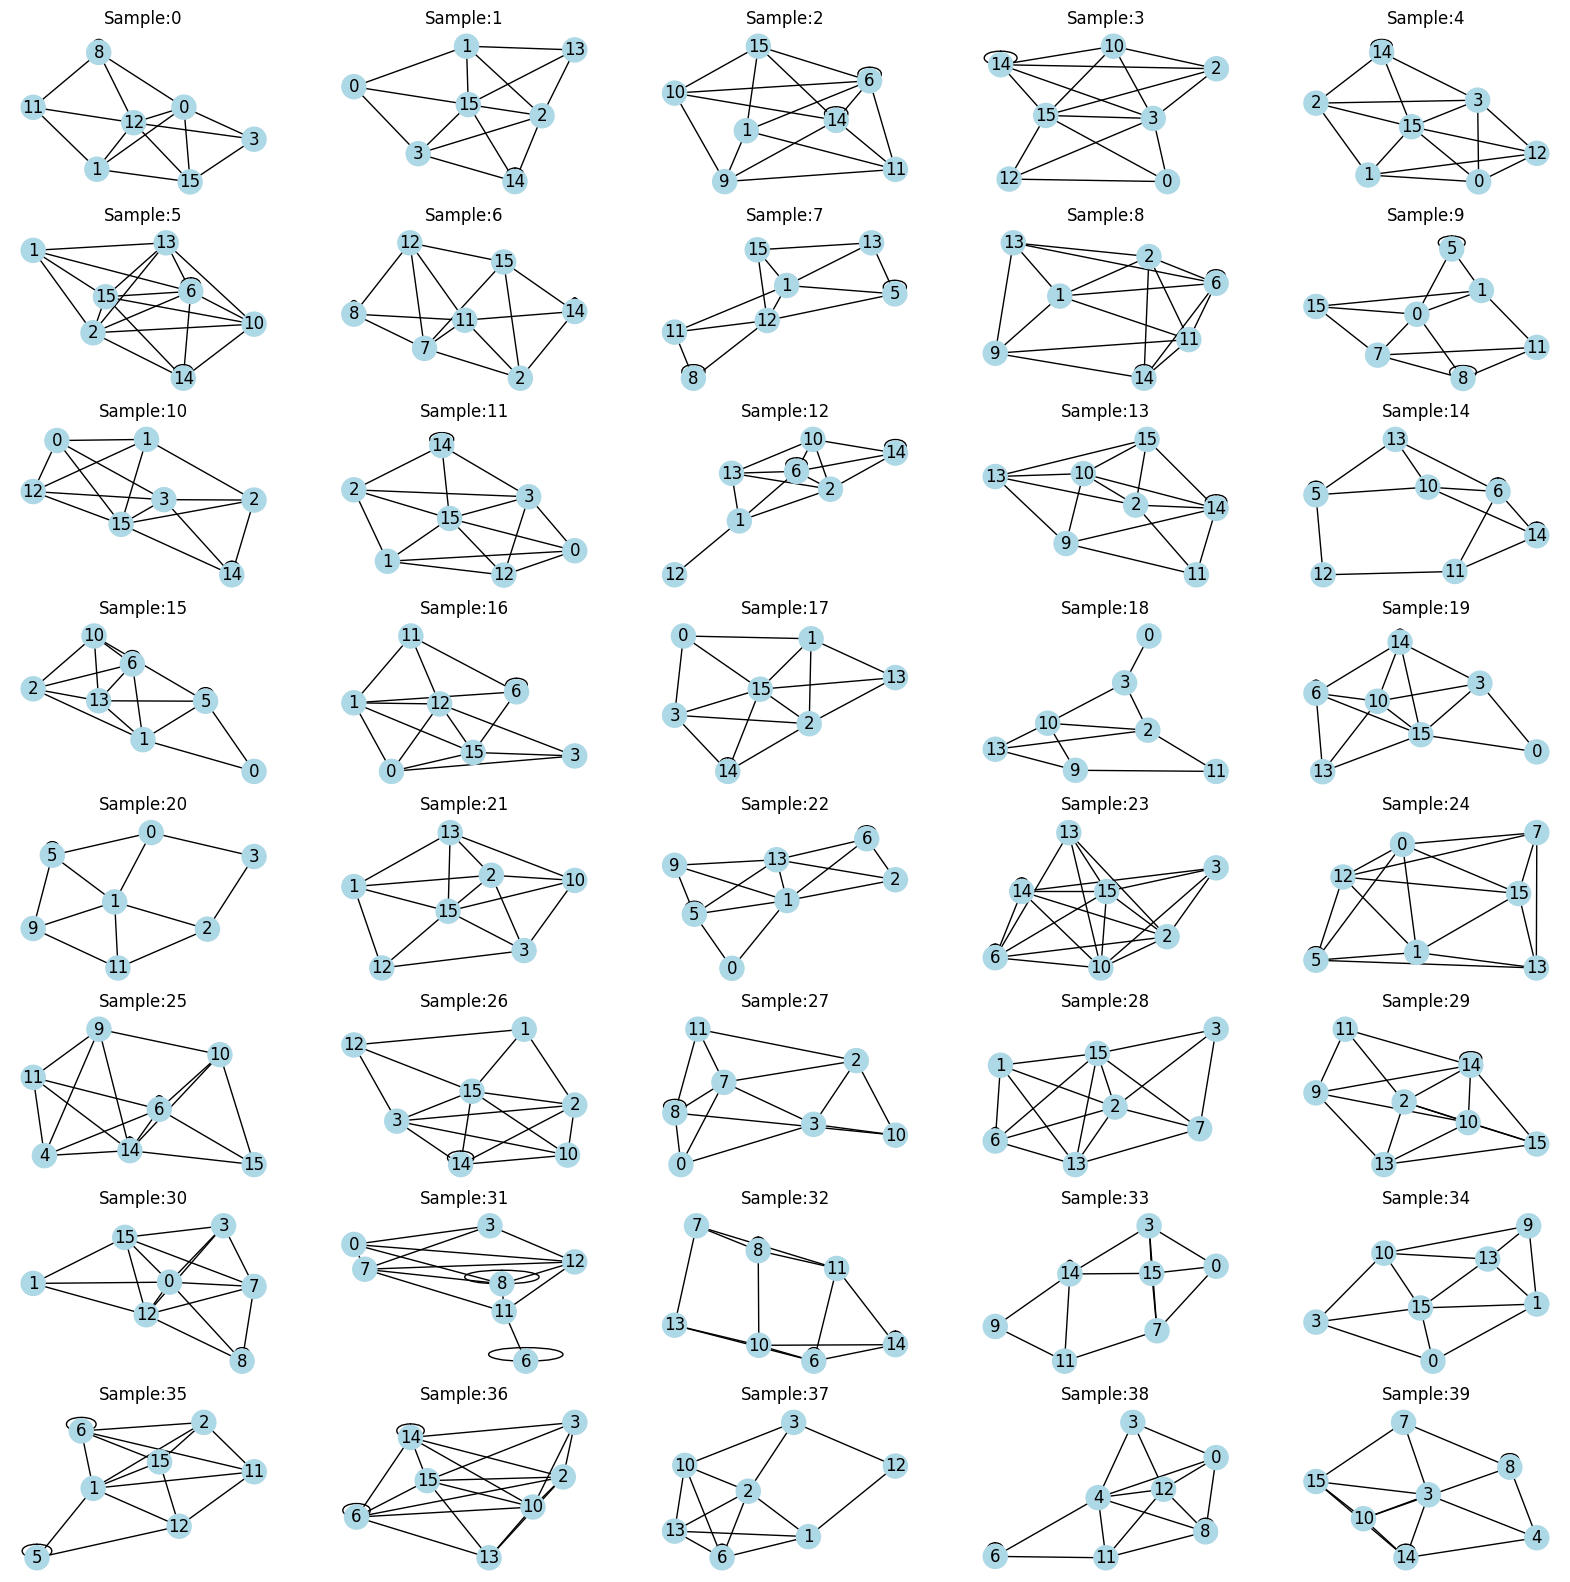

In [56]:
draw_subgraphs(Shrekhande_edge_index,16,7)

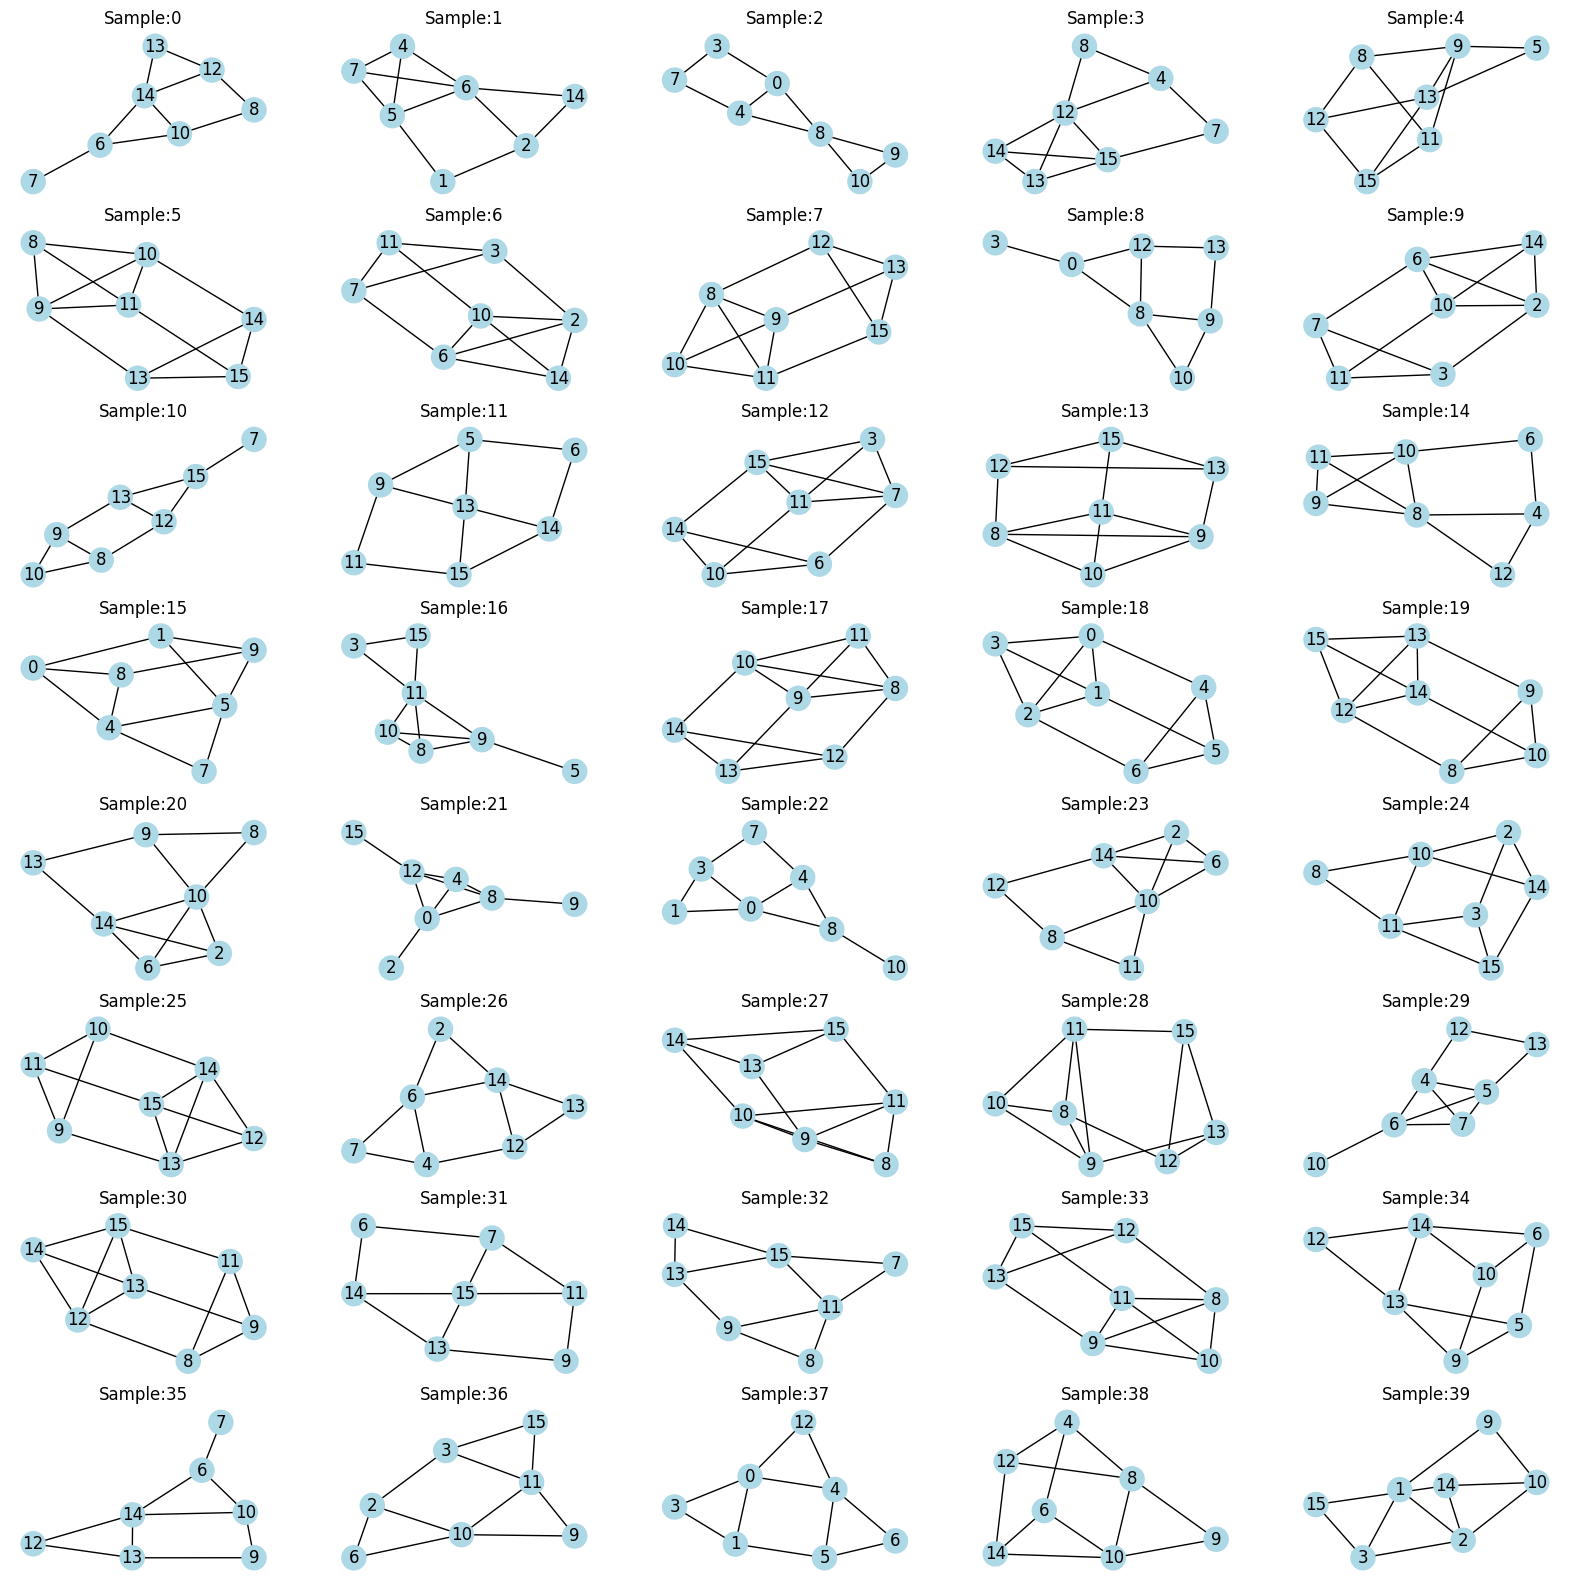

In [57]:
draw_subgraphs(Rooks_edge_index,16,7)

In [45]:
subgraph_wl_dist(Shrekhande_edge_index,30,16,7)

Counter({'c21bcc9c48cc6e1920e71d6d7e04c403': 5,
         'e7b58ed0b68f461dfea8eebe888e5007': 2,
         '89912a7aefaeb1bacd5987fe7cbf0530': 2,
         'e8b690bc814672e632a875fd629f72fb': 1,
         'de4e8e9b91494a043761f316020b2451': 1,
         '7e84e1a17c6f3cf4593030806765ded5': 1,
         '825307603cfaf91eeb70e9e29ea4d3be': 1,
         '24af1a531cdc116218c7a33cdc1cf0ca': 1,
         '91dd2c6af8c0d26cff8e8f2161f3fa20': 1,
         'c09e8f0307c7f2ad32e55606a51722ae': 1,
         'f4d726b4a48eb494309aaa2c271472ca': 1,
         '4f461d04a01f45d61f5b42104fec3db7': 1,
         'baf96ac54db0ce463eaf72db752e5d81': 1,
         '76a01c6735b384757c42ee7c7f00ac73': 1,
         '0fe19123cd4dfba46cafe995455dcd4c': 1,
         'f078504a6a7c9e9605af0120d36cb929': 1,
         '046856bad43ed57fdfe2eb54ee01fcc5': 1,
         '2552e5ba0ba6cdc3d3d89442e48fad96': 1,
         '57b336d3613d9b55d195f84642154a68': 1,
         'ff6e20cdc3786e58de7efe2de7ff3aff': 1,
         'c62be242a091c7a39941c92ef27344

In [46]:
subgraph_wl_dist(Rooks_edge_index,30,16,7)

Counter({'e6a3e8ebf6577b4d86204b4be0ab8962': 9,
         '7b1bf1f746156339af48423d6a88685b': 6,
         'afdd1459e2c9d286c3025291c3adde2b': 4,
         'fb4142e9e085a36bdbcfdb3e32263a86': 2,
         'f4b3e2d5b9b206cf3d5ac9b0bd9fc99e': 2,
         '116d50265c930ec84eb1d9be168ce447': 2,
         'e1f7e11a5bbf36196931ef07e8db5fd6': 2,
         '79f079bdd20909308e1e0903366482d1': 1,
         'a2d7e6433a7cd07b457f94869bbbb3e5': 1,
         '7b5b25528a9e0b28aa85de13ec9635f2': 1})

In [58]:
subgraph_wl_dist(Rooks_edge_index,30,16,7)-subgraph_wl_dist(Shrekhande_edge_index,30,16,7)

/home/mlrl/anaconda3/envs/memp/lib/python3.11/site-packages/networkx/algorithms/graph_hashing.py:211: UserWarning: The hashes produced for graphs without node or edge attributeschanged in v3.5 due to a bugfix (see documentation).
  node_labels = _init_node_labels(G, edge_attr, node_attr)


Counter({'e6a3e8ebf6577b4d86204b4be0ab8962': 8,
         '7b1bf1f746156339af48423d6a88685b': 5,
         'afdd1459e2c9d286c3025291c3adde2b': 5,
         'f4b3e2d5b9b206cf3d5ac9b0bd9fc99e': 4,
         '116d50265c930ec84eb1d9be168ce447': 2,
         'c8904ed526e4bcd1b87e9023c151f8a2': 2,
         'fb4142e9e085a36bdbcfdb3e32263a86': 1,
         'ef35bb63885285dd6df0ed764a703447': 1,
         'a2d7e6433a7cd07b457f94869bbbb3e5': 1,
         '82a700b7e65805c7c5752e0e8d1e6297': 1})

In [59]:
subgraph_wl_dist(Shrekhande_edge_index,30,16,7)-subgraph_wl_dist(Rooks_edge_index,30,16,7)

Counter({'c21bcc9c48cc6e1920e71d6d7e04c403': 5,
         '32cd9f05121110b39830de2c262d7058': 2,
         '03600d00361a6e03ef91bbdb174091fd': 2,
         '96f17702316a7db2edb97c5d2577539c': 1,
         'cbb0d7de44d9c0252c957593b0111fda': 1,
         'b898b675dcb5b552faef89ccba9a82d5': 1,
         'ed93711340059301408143d1437ae1d2': 1,
         '89912a7aefaeb1bacd5987fe7cbf0530': 1,
         '21bd2fd491bd59379f38f337e5069a75': 1,
         'e0759a4aff17e97c8b6887bbd08991e3': 1,
         'b5c048ef96aad03e883f56423cecc103': 1,
         '032e064f63ed1d5e4d15937ab12d263d': 1,
         'f60bc6f52ce52774e8424fe4a1840695': 1,
         'e7b58ed0b68f461dfea8eebe888e5007': 1,
         'e8b690bc814672e632a875fd629f72fb': 1,
         '925e7100ba688ccc28b461d21e881a90': 1,
         'bc6988eb609d83006611bb9a06fe4c14': 1,
         'eb8dcca22418a7bdeafb07602472f2a3': 1,
         'a52677c5b0a5997ec68d43ef62adb201': 1,
         '3482e3351d246d45d13510c254f6b92e': 1,
         'd0291547c063b8772d5e1c262de134